In [1]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import GridWorld_env
from replay_buffer import PrioritizedReplayBuffer
import gymnasium as gym
import random
import math
from itertools import count

device = "cuda" if torch.cuda.is_available() else "cpu"
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [3]:
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayBuffer(object):
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

In [4]:
class PriorityReplayBuffer(object):
    def __init__(self, capacity, alpha):
        """
        ### Initialize
        """
        # We use a power of $2$ for capacity because it simplifies the code and debugging
        self.capacity = capacity
        # $\alpha$
        self.alpha = alpha

        # Maintain segment binary trees to take sum and find minimum over a range
        self.priority_sum = [0 for _ in range(2 * self.capacity)]
        self.priority_min = [float('inf') for _ in range(2 * self.capacity)]

        # Current max priority, $p$, to be assigned to new transitions
        self.max_priority = 1.

        # Arrays for buffer
        self.data = {
            'obs': np.zeros(shape=(capacity, 4, 84, 84), dtype=np.uint8),
            'action': np.zeros(shape=capacity, dtype=np.int32),
            'reward': np.zeros(shape=capacity, dtype=np.float32),
            'next_obs': np.zeros(shape=(capacity, 4, 84, 84), dtype=np.uint8),
            'done': np.zeros(shape=capacity, dtype=np.bool)
        }
        # We use cyclic buffers to store data, and `next_idx` keeps the index of the next empty
        # slot
        self.next_idx = 0

        # Size of the buffer
        self.size = 0
    def add(self, obs, action, reward, next_obs, done):
        """
        ### Add sample to queue
        """

        # Get next available slot
        idx = self.next_idx

        # store in the queue
        self.data['obs'][idx] = obs
        self.data['action'][idx] = action
        self.data['reward'][idx] = reward
        self.data['next_obs'][idx] = next_obs
        self.data['done'][idx] = done

        # Increment next available slot
        self.next_idx = (idx + 1) % self.capacity
        # Calculate the size
        self.size = min(self.capacity, self.size + 1)

        # $p_i^\alpha$, new samples get `max_priority`
        priority_alpha = self.max_priority ** self.alpha
        # Update the two segment trees for sum and minimum
        self._set_priority_min(idx, priority_alpha)
        self._set_priority_sum(idx, priority_alpha)

    def _set_priority_min(self, idx, priority_alpha):
        """
        #### Set priority in binary segment tree for minimum
        """

        # Leaf of the binary tree
        idx += self.capacity
        self.priority_min[idx] = priority_alpha

        # Update tree, by traversing along ancestors.
        # Continue until the root of the tree.
        while idx >= 2:
            # Get the index of the parent node
            idx //= 2
            # Value of the parent node is the minimum of it's two children
            self.priority_min[idx] = min(self.priority_min[2 * idx], self.priority_min[2 * idx + 1])

    def _set_priority_sum(self, idx, priority):
        """
        #### Set priority in binary segment tree for sum
        """

        # Leaf of the binary tree
        idx += self.capacity
        # Set the priority at the leaf
        self.priority_sum[idx] = priority

        # Update tree, by traversing along ancestors.
        # Continue until the root of the tree.
        while idx >= 2:
            # Get the index of the parent node
            idx //= 2
            # Value of the parent node is the sum of it's two children
            self.priority_sum[idx] = self.priority_sum[2 * idx] + self.priority_sum[2 * idx + 1]

    def _sum(self):
        """
        #### $\sum_k p_k^\alpha$
        """

        # The root node keeps the sum of all values
        return self.priority_sum[1]

    def _min(self):
        """
        #### $\min_k p_k^\alpha$
        """

        # The root node keeps the minimum of all values
        return self.priority_min[1]

    def find_prefix_sum_idx(self, prefix_sum):
        """
        #### Find largest $i$ such that $\sum_{k=1}^{i} p_k^\alpha  \le P$
        """

        # Start from the root
        idx = 1
        while idx < self.capacity:
            # If the sum of the left branch is higher than required sum
            if self.priority_sum[idx * 2] > prefix_sum:
                # Go to left branch of the tree
                idx = 2 * idx
            else:
                # Otherwise go to right branch and reduce the sum of left
                #  branch from required sum
                prefix_sum -= self.priority_sum[idx * 2]
                idx = 2 * idx + 1

        # We are at the leaf node. Subtract the capacity by the index in the tree
        # to get the index of actual value
        return idx - self.capacity

    def sample(self, batch_size, beta):
        """
        ### Sample from buffer
        """

        # Initialize samples
        samples = {
            'weights': np.zeros(shape=batch_size, dtype=np.float32),
            'indexes': np.zeros(shape=batch_size, dtype=np.int32)
        }

        # Get sample indexes
        for i in range(batch_size):
            p = random.random() * self._sum()
            idx = self.find_prefix_sum_idx(p)
            samples['indexes'][i] = idx

        # $\min_i P(i) = \frac{\min_i p_i^\alpha}{\sum_k p_k^\alpha}$
        prob_min = self._min() / self._sum()
        # $\max_i w_i = \bigg(\frac{1}{N} \frac{1}{\min_i P(i)}\bigg)^\beta$
        max_weight = (prob_min * self.size) ** (-beta)

        for i in range(batch_size):
            idx = samples['indexes'][i]
            # $P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}$
            prob = self.priority_sum[idx + self.capacity] / self._sum()
            # $w_i = \bigg(\frac{1}{N} \frac{1}{P(i)}\bigg)^\beta$
            weight = (prob * self.size) ** (-beta)
            # Normalize by $\frac{1}{\max_i w_i}$,
            #  which also cancels off the $\frac{1}{N}$ term
            samples['weights'][i] = weight / max_weight

        # Get samples data
        for k, v in self.data.items():
            samples[k] = v[samples['indexes']]

        return samples

    def update_priorities(self, indexes, priorities):
        """
        ### Update priorities
        """

        for idx, priority in zip(indexes, priorities):
            # Set current max priority
            self.max_priority = max(self.max_priority, priority)

            # Calculate $p_i^\alpha$
            priority_alpha = priority ** self.alpha
            # Update the trees
            self._set_priority_min(idx, priority_alpha)
            self._set_priority_sum(idx, priority_alpha)

    def is_full(self):
        """
        ### Whether the buffer is full
        """
        return self.capacity == self.size

In [5]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.in_conv = nn.Conv3d(3, 32, 3, 1, 1)
        
        self.conv1 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, 1, 1),            
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, 1, 1),         
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, 1, 1),         
        )
        
        self.fc1 = nn.Linear((32 + 3)*input_dim * input_dim * input_dim, 512)
        self.actions = nn.Linear(512, action_dim)
        self.advantage = nn.Linear(512, 1)
    def forward(self, x):
        original_state = x
        
        x = self.in_conv(x)
        
        x = x + self.conv1(x)
        
        x = F.relu(x)
        
        x = x + self.conv2(x)
        x = F.relu(x)

        x = x + self.conv3(x)
        x = F.relu(x)
        
        x = torch.cat([x, original_state], dim=1)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu(x)
        actions = self.actions(x)
        advantage = self.advantage(x)
        x = advantage + (actions - actions.mean())
        return x

test = DQN(8, 7)
import torchinfo
torchinfo.summary(test, (1, 3, 8, 8, 8))

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 7]                    --
├─Conv3d: 1-1                            [1, 32, 8, 8, 8]          2,624
├─Sequential: 1-2                        [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-1                       [1, 32, 8, 8, 8]          27,680
│    └─ReLU: 2-2                         [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-3                       [1, 32, 8, 8, 8]          27,680
├─Sequential: 1-3                        [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-4                       [1, 32, 8, 8, 8]          27,680
│    └─ReLU: 2-5                         [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-6                       [1, 32, 8, 8, 8]          27,680
├─Sequential: 1-4                        [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-7                       [1, 32, 8, 8, 8]          27,680
│    └─ReLU: 2-8                         [1, 32, 8, 8, 8]     

In [6]:
BATCH_SIZE = 32
GAMMA = 0.8
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 500000
TAU = 0.005
STEPSIZE = 0.0000625

n_actions = 7
env = gym.make("GridWorld_env/GridWorld", dimension_size=4)
env.reset()

policy_net = DQN(4, 7)
target_net = DQN(4, 7)

policy_net.cuda()
target_net.cuda()
target_net.load_state_dict(policy_net.state_dict())

optimiser = optim.Adam(policy_net.parameters(), lr=STEPSIZE, eps=1.5e-4)
# memory = ReplayBuffer(256)
memory = PrioritizedReplayBuffer(obs_dim=(3,4,4,4), size=256)

steps_done = 0

In [7]:
def select_action(state, greedy = False):
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if greedy:
        return policy_net(state).max(1).indices.view(1,1)
        
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    

In [13]:
def boltzmann_action(state, num_actions):

    global steps_done
    steps_done +=1
    C = 5
    with torch.no_grad():
        
        Beta = C / (torch.sqrt(num_actions) + 0.05)
        mean_reward = policy_net(state)
        action_estimate =  mean_reward + Beta*torch.distributions.gumbel.Gumbel(torch.zeros(1,n_actions), torch.ones(1, n_actions)).sample().to(device)

    #print(action_estimate)
    action = torch.argmax(action_estimate).view(1,1)
    #print(action.device)
    return action


In [9]:
episode_durations = []

def plot_durations(show_result = False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
        plt.pause(0.001)
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())
                

In [14]:
def optimise_model():
    if len(memory) < BATCH_SIZE:
        return 0, 0
    # transitions = memory.sample(BATCH_SIZE)
    transitions = memory.sample_batch()
    # batch = Transition(*zip(*transitions))
    # batch = []
    batch = Transition(
        torch.tensor(transitions["obs"], device=device),
        torch.tensor(transitions["acts"], device=device, dtype=torch.int64),
        torch.tensor(transitions["next_obs"], device=device),
        torch.tensor(transitions["rews"], device=device)
    )
    indices = transitions["indices"]
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch.next_state if s is not None])
    
    state_batch = batch.state
    action_batch = batch.action
    reward_batch = batch.reward
    
    tmp = policy_net(state_batch)
    state_action_values = tmp.gather(1, action_batch.unsqueeze(1))
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    
    #double dqn
    max_a = policy_net(non_final_next_states).detach().max(1).indices
    next_state_values[non_final_mask] = target_net(non_final_next_states).detach().gather(1, max_a.unsqueeze(1)).squeeze(1)
    #next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    expected_state_action_values = GAMMA * next_state_values + reward_batch
    expected_state_action_values = expected_state_action_values.detach()
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimiser.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimiser.step()
    
    new_priorities = torch.abs(state_action_values - expected_state_action_values.unsqueeze(1)).detach().cpu().numpy() + 1e-7 #loss.detach().cpu().numpy() + 1e-6
    #print(len(indices), new_priorities.shape, new_priorities)
    memory.update_priorities(indices, new_priorities)
    return loss.item(), reward_batch.float()
        

Episode: 0 Loss 0.019113056361675262 Mean Sample Reward -1.1875:
[]


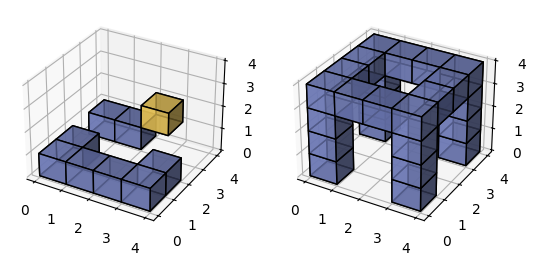

Episode: 10 Loss 0.0018726007547229528 Mean Sample Reward -1.0:
[]


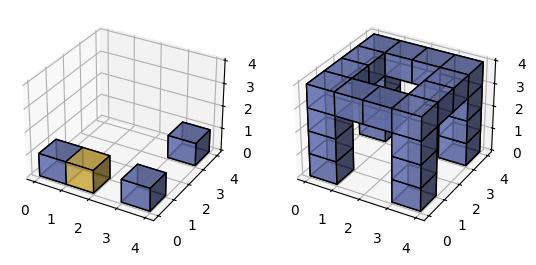

Episode: 20 Loss 0.0011218991130590439 Mean Sample Reward -0.9375:
[]


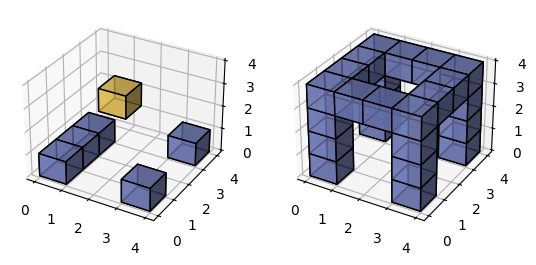

Episode: 30 Loss 0.0006244146497920156 Mean Sample Reward -1.0:
[]


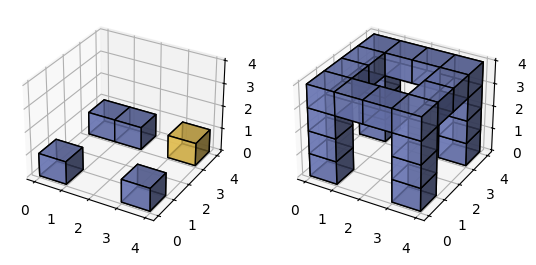

Episode: 40 Loss 0.000828866264782846 Mean Sample Reward -0.9375:
[]


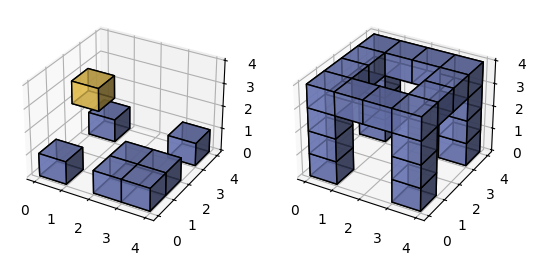

KeyboardInterrupt: 

In [15]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 1

num_actions = torch.zeros(n_actions, device=device)


for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = boltzmann_action(state, num_actions)

        num_actions[action] +=1

        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        # memory.push(state, action, next_state, reward)
        memory.store(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), truncated)
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        l, r = optimise_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    if i_episode % 10 == 0:
        print("Episode: {0} Loss {1} Mean Sample Reward {2}:" .format(i_episode, l, r.mean().item()))
        print(env.unwrapped.get_sequence())
        env.unwrapped.render()
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


In [ ]:
torch.save(policy_net, "policy_converged.pt")
torch.save(target_net, "target_converged.pt")

In [ ]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = select_action(state, greedy = True)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the transition in memory
    #memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    if terminated or truncated:
        break
    env.unwrapped.render()

    # Perform one step of the optimization (on the policy network)


In [ ]:
env.reset()
state = env.get_obs()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

target_net(state)

In [ ]:
env.step(3)
env.render()
state = env.get_obs()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

policy_net(state)

In [ ]:
torch.save(policy_net, "policy.pt")

In [ ]:
torch.save(target_net, "target.pt")